# Stockpredictor
## Introduzione
StockPredictor è un progetto di previsione dell'andamento degli stock tramite modello LSTM.
In questo file è presente sia il codice necessario allo sviluppo del modello che quello relativo alla stesura della documentazione del progetto.

## Data manipulation
In questa sezione sono racchiuse tutte le operazioni effettuate sui dati

### Raccolta dei dati
Definiamo una funzione per la raccolta dei dati

In [3]:
# Import delle librerie necessarie
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Lista dei ticker che vogliamo scaricare
tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN"]

# Funzione per scaricare i dati di ciascun ticker e verificare la data di inizio
def get_stock_data(ticker, start_date='2010-01-01', end_date=None):
    if end_date is None:
        end_date = pd.to_datetime("today").strftime('%Y-%m-%d')

    print(f"\nScaricando dati per {ticker} dal {start_date} al {end_date}...")
    data = yf.download(ticker, start=start_date, end=end_date)

    if data.empty:
        print(f"⚠️ Nessun dato disponibile per {ticker} nel periodo richiesto.")
    else:
        first_date = data.index.min().strftime('%Y-%m-%d')
        print(f"📈 Dati disponibili dal {first_date}. Numero di record: {len(data)}")

    # Aggiungiamo il ticker come colonna
    data['Ticker'] = ticker

    data.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']

    return data

### Preprocessing
Analizziamo le caratteristiche di Google per capire quali feature devono subire riduzione del rumore.

Prima stampiamo la descrizione del dataset

In [5]:
# Trova il primo mese disponibile
first_month = ('2015')

data = get_stock_data('GOOGL')

# Filtra il dataset per il primo mese
data_first_month = data.loc[first_month]
data_first_month.describe()


Scaricando dati per GOOGL dal 2010-01-01 al 2025-02-12...


[*********************100%***********************]  1 of 1 completed

📈 Dati disponibili dal 2010-01-04. Numero di record: 3801


,Open,High,Low,Close,Volume
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,30.887441,31.171679,30.587030,30.890260,4.339637e+07
std,4.343829,4.397117,4.282566,4.346961,2.264566e+07
min,24.763231,24.923649,24.456841,24.871837,1.041200e+07
25%,27.233900,27.405030,27.043840,27.257440,3.138400e+07
50%,28.590358,28.918168,28.308379,28.578152,3.796200e+07
75%,33.959270,34.577776,33.675922,34.088924,4.767250e+07
max,39.554615,39.790261,39.217834,39.554614,2.571620e+08


Plottiamo il volume

<Axes: xlabel='Date'>

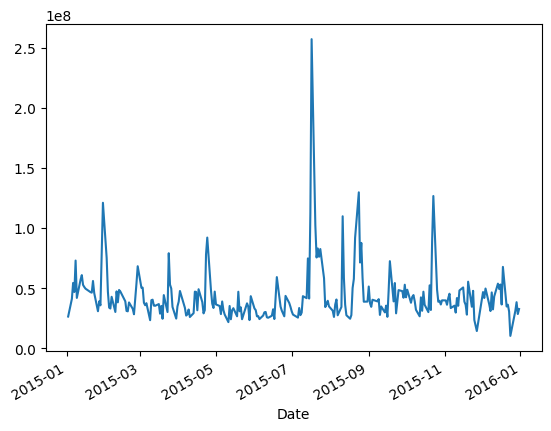

In [6]:
data_first_month['Volume'].plot()

Applichiamo la rolling window a tutti i campi e analizziamo nuovamente le caratteristiche

In [7]:
# Riduzione del rumore tramite media mobile
for col in ["Open", "High", "Low", "Close", "Volume"]:
        data_first_month[col] = data_first_month[col].rolling(window=10, min_periods=1).mean()

data_first_month.describe()

C:\Users\petrillo\AppData\Local\Temp\ipykernel_4940\1909803875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_first_month[col] = data_first_month[col].rolling(window=10, min_periods=1).mean()


,Open,High,Low,Close,Volume
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,30.655952,30.942090,30.358551,30.663186,4.354561e+07
std,4.195959,4.250366,4.130599,4.193816,1.201376e+07
min,25.151922,25.418605,24.927984,25.201243,2.648000e+07
25%,27.304519,27.496535,27.108654,27.317073,3.611010e+07
50%,28.118519,28.337599,27.896075,28.119515,4.090080e+07
75%,33.460428,33.869482,33.081203,33.561897,4.736735e+07
max,38.542580,38.893359,38.269920,38.628419,9.644780e+07


Solo il volume sembra aver avuto un cambiamento rilevante, riplottiamolo per verificare

<Axes: xlabel='Date'>

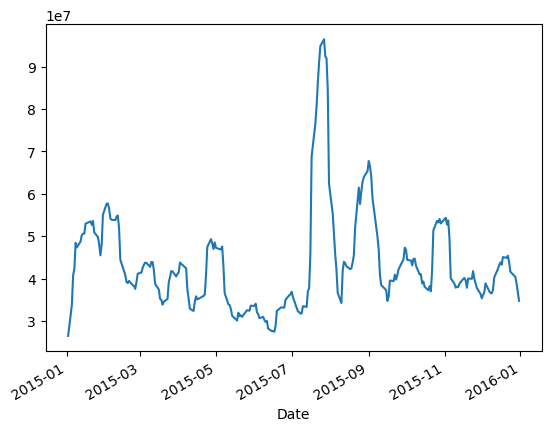

In [8]:
data_first_month['Volume'].plot()

Alla luce dei risultati ottenuti, procediamo con la raccolta dei dati necessari al modello e riduciamo il rumore relativo al volume.

Successivamente, uniamo tutti i dataset in uno

In [9]:

dataset_list = []
for ticker in tickers:
    data = get_stock_data(ticker)
    data['Volume'] = data['Volume'].rolling(window=10, min_periods=1).mean()
    dataset_list.append(data)

for i in range(len(dataset_list)):
    dataset_list[i] = dataset_list[i].reset_index()  # Resetta l’indice
    dataset_list[i]['Date'] = pd.to_datetime(dataset_list[i]['Date'])  # Assicura che Date sia un datetime
    dataset_list[i] = dataset_list[i].set_index('Date')  # Imposta Date come indice

all_data = pd.concat(dataset_list, axis=0, join='outer')  # Combina tutti i dataset
all_data = all_data.sort_index()  # Ordina per data

all_data.dropna(inplace=True)

all_data


Scaricando dati per AAPL dal 2010-01-01 al 2025-02-12...


[*********************100%***********************]  1 of 1 completed


📈 Dati disponibili dal 2010-01-04. Numero di record: 3801

Scaricando dati per MSFT dal 2010-01-01 al 2025-02-12...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

📈 Dati disponibili dal 2010-01-04. Numero di record: 3801

Scaricando dati per GOOGL dal 2010-01-01 al 2025-02-12...


📈 Dati disponibili dal 2010-01-04. Numero di record: 3801

Scaricando dati per TSLA dal 2010-01-01 al 2025-02-12...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 Dati disponibili dal 2010-06-29. Numero di record: 3679

Scaricando dati per AMZN dal 2010-01-01 al 2025-02-12...
📈 Dati disponibili dal 2010-01-04. Numero di record: 3801


,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2010-01-04,6.440331,6.455076,6.391278,6.422876,493729600.0,AAPL
2010-01-04,15.627781,15.696601,15.565196,15.632768,78169752.0,GOOGL
2010-01-04,6.695000,6.830500,6.657000,6.812500,151998000.0,AMZN
2010-01-04,23.300680,23.413607,23.029654,23.052240,38409100.0,MSFT
2010-01-05,15.558962,15.654961,15.497873,15.638504,99118782.0,GOOGL
...,...,...,...,...,...,...
2025-02-11,411.440002,412.489594,409.299988,409.640015,25303694.1,MSFT
2025-02-11,232.619995,235.229996,228.130005,228.199997,51507866.0,AAPL
2025-02-11,185.320007,186.940002,184.279999,185.110001,33743512.7,GOOGL


Controlliamo che non ci siano valori nulli

In [10]:
# Verifica se ci sono NaN nell'intero dataset
has_nan = all_data.isna().any().any()

if has_nan:
    print("Ci sono valori NaN nel dataset.")
else:
    print("Non ci sono valori NaN nel dataset.")


Non ci sono valori NaN nel dataset.


Normalizziamo con min-max tutte le feature del dataset unito

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Seleziona solo le colonne numeriche da normalizzare
columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume']

# Applica la normalizzazione separatamente per ogni ticker
normalized_data_list = []
for ticker in all_data['Ticker'].unique():
    subset = all_data[all_data['Ticker'] == ticker].copy()
    scaler = MinMaxScaler()
    subset[columns_to_normalize] = scaler.fit_transform(subset[columns_to_normalize])
    normalized_data_list.append(subset)

# Unisci di nuovo i dati normalizzati
all_data_normalized = pd.concat(normalized_data_list)

# Mostra i primi valori normalizzati
all_data_normalized


,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2010-01-04,0.002613,0.002193,0.002647,0.002514,0.438714,AAPL
2010-01-05,0.002657,0.002322,0.002751,0.002653,0.490693,AAPL
2010-01-06,0.002251,0.002279,0.002452,0.002627,0.492084,AAPL
2010-01-07,0.002204,0.001896,0.002248,0.002313,0.474754,AAPL
2010-01-08,0.002371,0.001896,0.002250,0.002140,0.458681,AAPL
...,...,...,...,...,...,...
2025-02-05,0.787618,0.794535,0.820421,0.813847,0.136641,TSLA
2025-02-06,0.779577,0.767885,0.793368,0.783351,0.142497,TSLA
2025-02-07,0.753053,0.778451,0.787147,0.777370,0.145481,TSLA


Dividiamo il dataset in finestre temporali (dim 60 gg)

In [ ]:
import numpy as np

# Parametri
window_size = 60  # Dimensione della finestra temporale
forecast_horizon = 7  # Giorni futuri da prevedere
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']  # Colonne di interesse

# Funzione per creare finestre temporali con multi-step forecasting
def create_time_windows_per_ticker(data, window_size, forecast_horizon):
    X, y = [], []

    tickers = data['Ticker'].unique()  # Trova i ticker unici
    for ticker in tickers:
        ticker_data = data[data['Ticker'] == ticker].reset_index(drop=True)

        for i in range(window_size, len(ticker_data) - forecast_horizon):
            # Finestra temporale di input
            X.append(ticker_data[feature_columns].iloc[i-window_size:i].values)
            # Prevedi i prossimi 'forecast_horizon' giorni di prezzo di chiusura
            future_returns = ticker_data['Close'].iloc[i:i+forecast_horizon].values
            y.append(future_returns)

    X = np.array(X)
    y = np.array(y)
    return X, y

# Creazione delle finestre temporali
X, y = create_time_windows_per_ticker(all_data_normalized, window_size, forecast_horizon)

# Verifica delle dimensioni degli array risultanti
print(f"Dimensione di X: {X.shape}")  # (n_finestre, 60, n_features)
print(f"Dimensione di y: {y.shape}")  # (n_finestre, 7)

# Visualizzazione di un esempio di finestra temporale
print("Esempio di X:", X[0])
print("Esempio di y:", y[0])



Dimensione di X: (18548, 60, 5)
Dimensione di y: (18548, 7)
Esempio di X: [[2.61252843e-03 2.19257954e-03 2.64671450e-03 2.51379064e-03
  4.38713620e-01]
 [2.65654646e-03 2.32176442e-03 2.75076340e-03 2.65344646e-03
  4.90693102e-01]
 [2.25086846e-03 2.27910020e-03 2.45176977e-03 2.62718752e-03
  4.92084281e-01]
 [2.20446772e-03 1.89628575e-03 2.24845008e-03 2.31326011e-03
  4.74753750e-01]
 [2.37102215e-03 1.89628477e-03 2.24964831e-03 2.14018134e-03
  4.58681469e-01]
 [2.14855309e-03 2.01479989e-03 2.17668920e-03 2.43858807e-03
  4.50308119e-01]
 [1.86421637e-03 1.63198715e-03 1.93390278e-03 2.00768351e-03
  4.62480897e-01]
 [2.21279403e-03 1.76946863e-03 1.65643807e-03 1.85013043e-03
  4.72983832e-01]
 [2.06765388e-03 1.71376609e-03 2.24486100e-03 2.11750328e-03
  4.62679979e-01]
 [1.65127063e-03 1.84888017e-03 1.86812862e-03 2.21538252e-03
  4.69926065e-01]
 [2.73506107e-03 2.27435349e-03 2.03197622e-03 1.90503378e-03
  4.92632949e-01]
 [2.34128911e-03 2.31702842e-03 2.30227603e-03

Dividiamo in training e test set

In [14]:
from sklearn.model_selection import train_test_split

# Suddividere i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## Model definition

Istanziamo il modello LSTM con le caratteristiche decise

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Crea il modello LSTM
model = Sequential()
model.add(LSTM(units=512, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout per evitare overfitting
model.add(Dense(forecast_horizon))  # Layer finale per la previsione del valore 'Close'

# Compilare il modello
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Riassunto del modello
model.summary()


q:\Snake\envs\stock\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 512)            │     1,060,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,064,455 (4.06 MB)

 Trainable params: 1,064,455 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

Addestriamo il modello

In [22]:
# Allenare il modello
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 59s 127ms/step - loss: 0.0012 - val_loss: 9.1720e-04
Epoch 2/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 59s 127ms/step - loss: 6.2913e-04 - val_loss: 6.4874e-04
Epoch 3/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 59s 128ms/step - loss: 5.0975e-04 - val_loss: 5.8963e-04
Epoch 4/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 59s 127ms/step - loss: 4.5785e-04 - val_loss: 5.8023e-04
Epoch 5/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 59s 128ms/step - loss: 4.3156e-04 - val_loss: 5.4954e-04
Epoch 6/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 59s 127ms/step - loss: 3.9855e-04 - val_loss: 5.2919e-04
Epoch 7/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 57s 124ms/step - loss: 3.5853e-04 - val_loss: 5.4917e-04
Epoch 8/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 57s 123ms/step - loss: 3.4121e-04 - val_loss: 5.0173e-04
Epoch 9/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 57s 123ms/step - loss: 3.4532e-04 - val_loss: 4.9434e-04
Epoch 10/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 58s 124ms/step - loss: 3.2376e-04 - val_loss: 4.9181e-04
Epoch 11/20
464/464 ━━━━━━━━━━━━━

## Model evaluation

Facciamo una predizione sui dati di test e plottiamo una finestra casuale di 7 giorni

116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


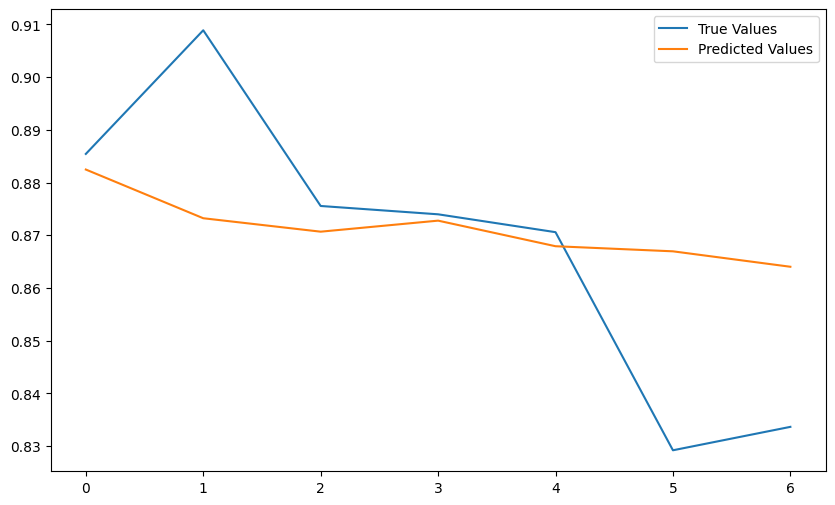

Shape of y_test: (3710, 7)
Shape of predictions: (3710, 7)


In [23]:
# Fare previsioni sui dati di test
predictions = model.predict(X_test)

# Visualizzare i risultati
plt.figure(figsize=(10,6))
plt.plot(y_test[3700], label='True Values')
plt.plot(predictions[3700], label='Predicted Values')
plt.legend()
plt.show()

print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of predictions: {predictions.shape}")


Controlliamo la qualità degli output su tutto il dataset confrontando la media dei risultati reali e quella delle previsioni

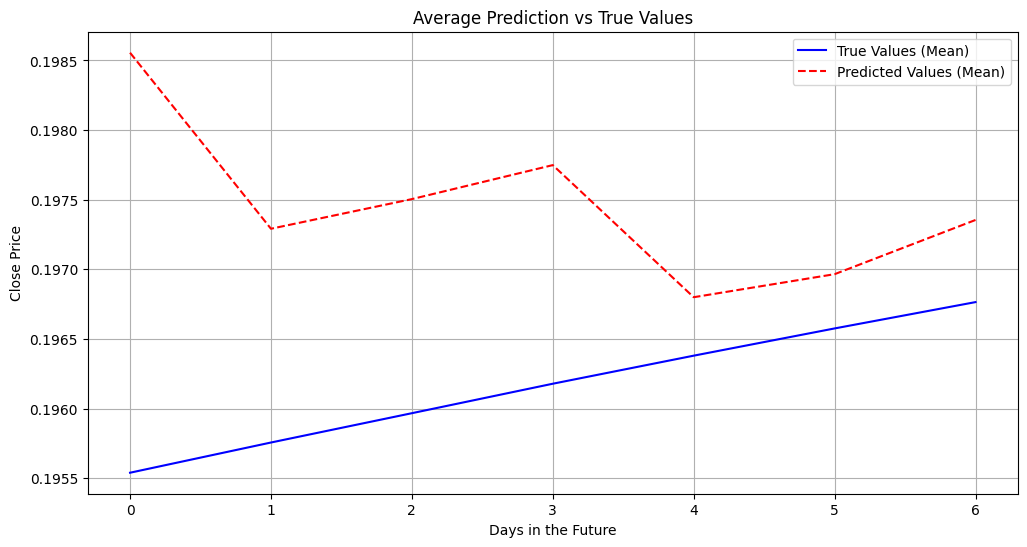

In [24]:
# Calcola la media lungo tutte le finestre temporali
y_test_mean = np.mean(y_test, axis=0)
predictions_mean = np.mean(predictions, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(y_test_mean, label='True Values (Mean)', color='blue')
plt.plot(predictions_mean, label='Predicted Values (Mean)', color='red', linestyle='dashed')
plt.xlabel('Days in the Future')
plt.ylabel('Close Price')
plt.title('Average Prediction vs True Values')
plt.legend()
plt.grid(True)
plt.show()

Ora calcoliamo i parametri di efficienza

=== Valori di Controllo Qualità ===
Mean Squared Error (MSE): 0.0004
Mean Absolute Error (MAE): 0.0101
R² Score: 0.9933


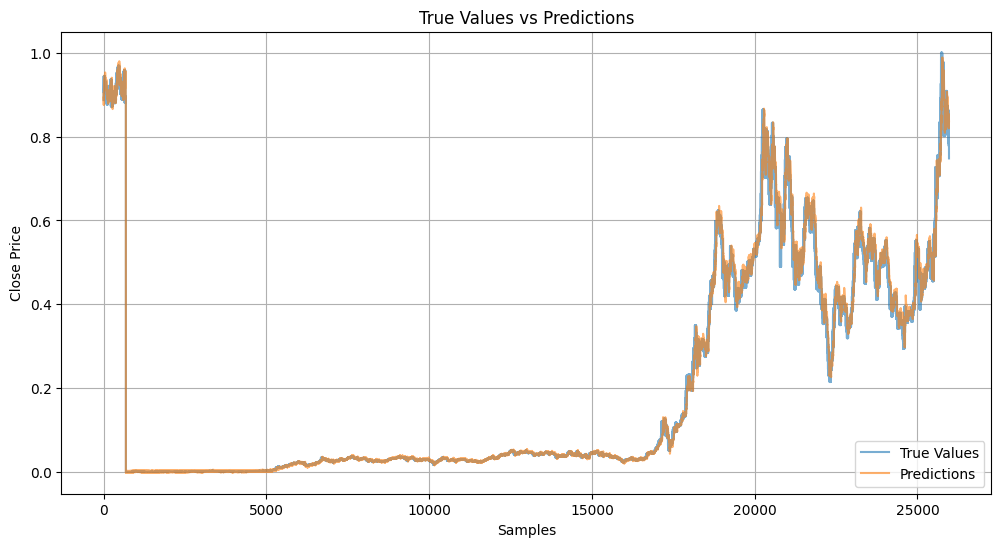

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcola MSE, MAE e R²
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())
r2 = r2_score(y_test.flatten(), predictions.flatten())

# Mostra i risultati
print("=== Valori di Controllo Qualità ===")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Visualizzazione delle differenze tra i valori reali e le previsioni
plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten(), label="True Values", alpha=0.6)
plt.plot(predictions.flatten(), label="Predictions", alpha=0.6)
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.title('True Values vs Predictions')
plt.legend()
plt.grid(True)
plt.show()


## Using the model

Creiamo una funzione che predice l'andamento di uno stock qualsiasi dato  in input

In [26]:
def predictaa(name, a):
    newdata = get_stock_data(name)
    newdata['Volume'] = newdata['Volume'].rolling(window=10, min_periods=1).mean()

    columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume']

    scaler = MinMaxScaler()
    newdata[columns_to_normalize] = scaler.fit_transform(newdata[columns_to_normalize])

    X, y = create_time_windows_per_ticker(newdata, window_size, 7)
    predictions = model.predict(X)

    mse = mean_squared_error(y.flatten(), predictions.flatten())
    mae = mean_absolute_error(y.flatten(), predictions.flatten())
    r2 = r2_score(y.flatten(), predictions.flatten())

    # Mostra i risultati
    print("=== Valori di Controllo Qualità ===")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Calcoliamo l'errore percentuale
    percentage_change = np.abs((y.flatten() - predictions.flatten()) / y.flatten()) * 100

    # Visualizziamo qualche statistica utile
    mean_percentage_change = np.mean(percentage_change)
    max_percentage_change = np.max(percentage_change)
    min_percentage_change = np.min(percentage_change)

    print(f"Mean Percentage Change: {mean_percentage_change:.2f}%")
    print(f"Max Percentage Change: {max_percentage_change:.2f}%")
    print(f"Min Percentage Change: {min_percentage_change:.2f}%")


    plt.figure(figsize=(12, 6))
    plt.plot(y[a], label='Valori reali')
    plt.plot(predictions[a], label='Predizioni')
    plt.legend()
    plt.title('Confronto tra valori reali e predizioni per il nuovo stock')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(percentage_change, label='Percentage Change (%)', color='orange')
    plt.axhline(y=mean_percentage_change, color='red', linestyle='--', label='Mean % Change')
    plt.xlabel('Prediction Index')
    plt.ylabel('Percentage Change (%)')
    plt.legend()
    plt.title('Percentage Change between True and Predicted Values')
    plt.show()



Proviamo la funzione con un nuovo stock e controlliamo anche qui grafici e parametri di efficienza


Scaricando dati per NFLX dal 2010-01-01 al 2025-02-12...


[*********************100%***********************]  1 of 1 completed


📈 Dati disponibili dal 2010-01-04. Numero di record: 3801
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
=== Valori di Controllo Qualità ===
Mean Squared Error (MSE): 0.0002
Mean Absolute Error (MAE): 0.0091
R² Score: 0.9946
Mean Percentage Change: 9.71%
Max Percentage Change: 612.54%
Min Percentage Change: 0.00%


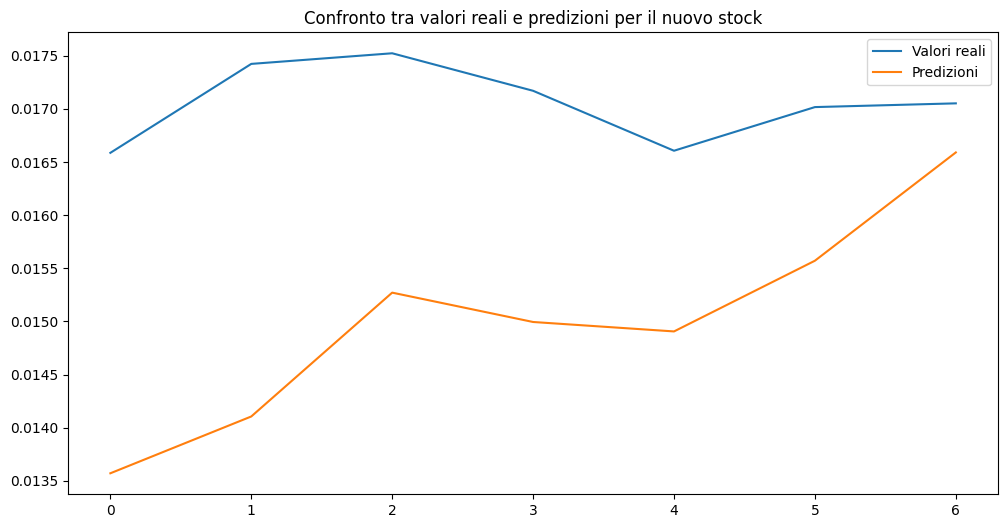

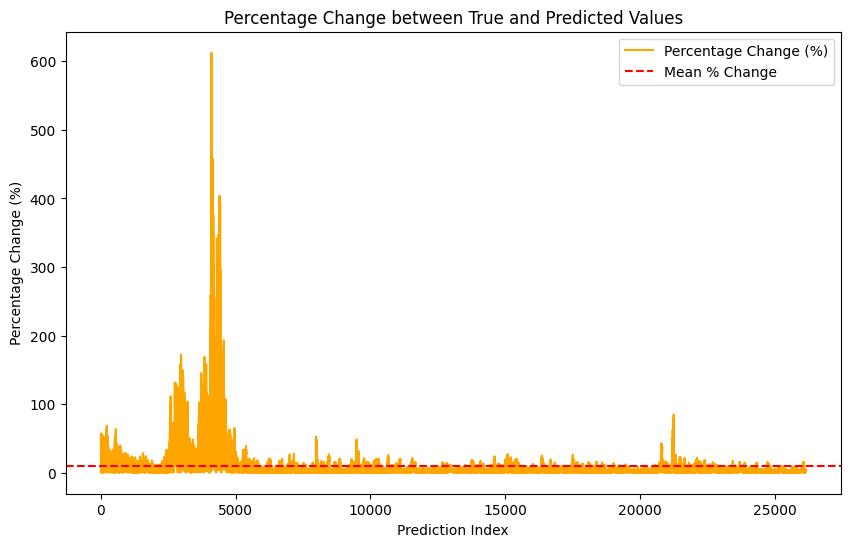

In [27]:
predictaa('NFLX', 150)

Funzione per denormalizzare

In [51]:
def denormalize(scaled_data, original_data):
    min_val = original_data.min()
    max_val = original_data.max()
    return scaled_data * (max_val - min_val) + min_val

Ora creiamo una funzione che effetivamente preveda il futuro

In [ ]:
def predict_next_days(model, name, n_days=7):
    """
    Predice i prossimi n_days basandosi sugli ultimi 60 giorni di dati.
    """

    predictions = []

    data = get_stock_data(name)

    data['Volume'] = data['Volume'].rolling(window=10, min_periods=1).mean()

    columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume']

    scaler = MinMaxScaler()
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

    # Prendi gli ultimi 60 giorni come input iniziale
    last_60_days = data[-60:].drop(columns=["Ticker"]).values

    print(last_60_days.shape)

    input_data = last_60_days.reshape((1, 60, 5))

    # Fai la prima previsione di 7 giorni
    next_day_features = model.predict(input_data)  # Dimensione di next_day_features: (1, 7, 5)

    next_day_features = denormalize(next_day_features, data['Close'])

    for i in range (7):
        predictions.append(next_day_features[0][i])

    return predictions

E proviamo a prevedere WLMT

In [63]:
future_predictions = predict_next_days(model, 'BBY')


Scaricando dati per BBY dal 2010-01-01 al 2025-02-12...


[*********************100%***********************]  1 of 1 completed

📈 Dati disponibili dal 2010-01-04. Numero di record: 3801
(60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Visualizziamo il risultato

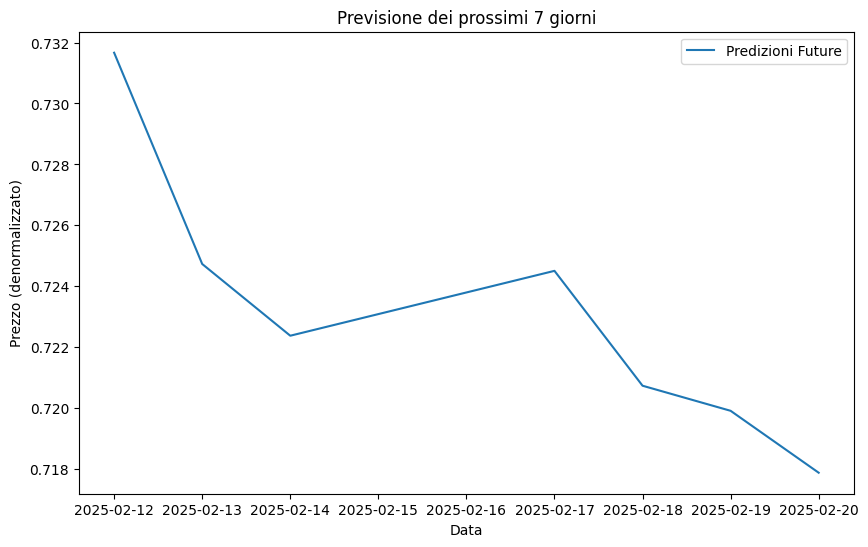

In [64]:
dates = pd.date_range(start=all_data.index[-1], periods=8, freq='B')[1:]  # Date dei prossimi 7 giorni (escludendo l'ultimo giorno)
plt.figure(figsize=(10, 6))
plt.plot(dates, future_predictions, label='Predizioni Future')
plt.xlabel('Data')
plt.ylabel('Prezzo (denormalizzato)')
plt.title('Previsione dei prossimi 7 giorni')
plt.legend()
plt.show()